In [ ]:
from statsmodels.stats.diagnostic import acorr_breusch_godfrey
import statsmodels.api as sm
import numpy as np
import pandas as pd
from statsmodels.tools.tools import add_constant
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.formula.api import ols, logit
from statsmodels.api import qqplot
import plotly.express as px
from statsmodels.stats.outliers_influence import variance_inflation_factor,reset_ramsey
# Heteroscedasticty tests
from statsmodels.stats.diagnostic import het_goldfeldquandt
from statsmodels.stats.diagnostic import het_white

# Autocorrelation test

# normality of residuals
from scipy.stats import normaltest, ks_2samp, cramervonmises
from statsmodels.stats.stattools import jarque_bera

https://www.kaggle.com/datasets/nikhil7280/student-performance-multiple-linear-regression

In [4]:


data = pd.read_csv(r"csvki\student.csv")


data.rename(columns={"Sample Question Papers Practiced": "sample_papers"}, inplace=True)
data.rename(columns={"Hours Studied": "hours_studied"}, inplace=True)
data.rename(columns={"Previous Scores": "previous_scores"}, inplace=True)
data.rename(columns={"Extracurricular Activities": "extracurricular_activities"}, inplace=True)
data.rename(columns={"Sleep Hours": "sleep_hours"}, inplace=True)
data.rename(columns={"Performance Index": "perform_index"}, inplace=True)

data["extracurricular_activities"] = data["extracurricular_activities"].map({"No":0,"Yes":1})


data.head()




,hours_studied,previous_scores,extracurricular_activities,sleep_hours,sample_papers,perform_index
0,7,99,1,9,1,91.0
1,4,82,0,4,2,65.0
2,8,51,1,7,2,45.0
3,5,52,1,5,2,36.0
4,7,75,0,8,5,66.0


In [5]:
data.dtypes

hours_studied                   int64
previous_scores                 int64
extracurricular_activities      int64
sleep_hours                     int64
sample_papers                   int64
perform_index                 float64
dtype: object

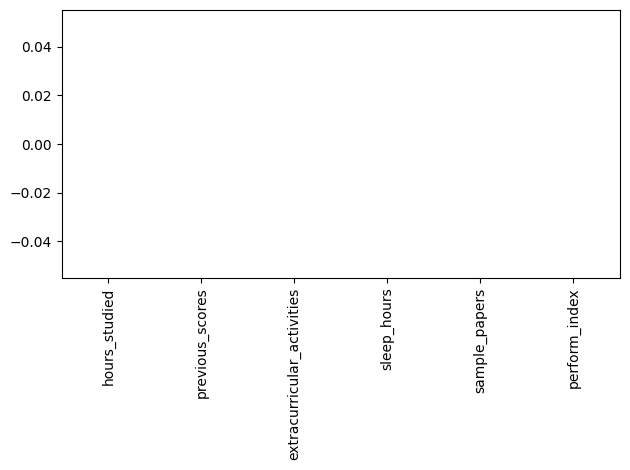

In [6]:

data.isna().sum().plot(kind="bar")

plt.xticks(rotation=90) 
plt.tight_layout()
plt.show()

In [7]:

data.info()



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 6 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   hours_studied               10000 non-null  int64  
 1   previous_scores             10000 non-null  int64  
 2   extracurricular_activities  10000 non-null  int64  
 3   sleep_hours                 10000 non-null  int64  
 4   sample_papers               10000 non-null  int64  
 5   perform_index               10000 non-null  float64
dtypes: float64(1), int64(5)
memory usage: 468.9 KB


In [8]:
data.describe()


,hours_studied,previous_scores,extracurricular_activities,sleep_hours,sample_papers,perform_index
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,4.992900,69.445700,0.494800,6.530600,4.583300,55.224800
std,2.589309,17.343152,0.499998,1.695863,2.867348,19.212558
min,1.000000,40.000000,0.000000,4.000000,0.000000,10.000000
25%,3.000000,54.000000,0.000000,5.000000,2.000000,40.000000
50%,5.000000,69.000000,0.000000,7.000000,5.000000,55.000000
75%,7.000000,85.000000,1.000000,8.000000,7.000000,71.000000
max,9.000000,99.000000,1.000000,9.000000,9.000000,100.000000


# EDA

In [9]:
data.head()

,hours_studied,previous_scores,extracurricular_activities,sleep_hours,sample_papers,perform_index
0,7,99,1,9,1,91.0
1,4,82,0,4,2,65.0
2,8,51,1,7,2,45.0
3,5,52,1,5,2,36.0
4,7,75,0,8,5,66.0


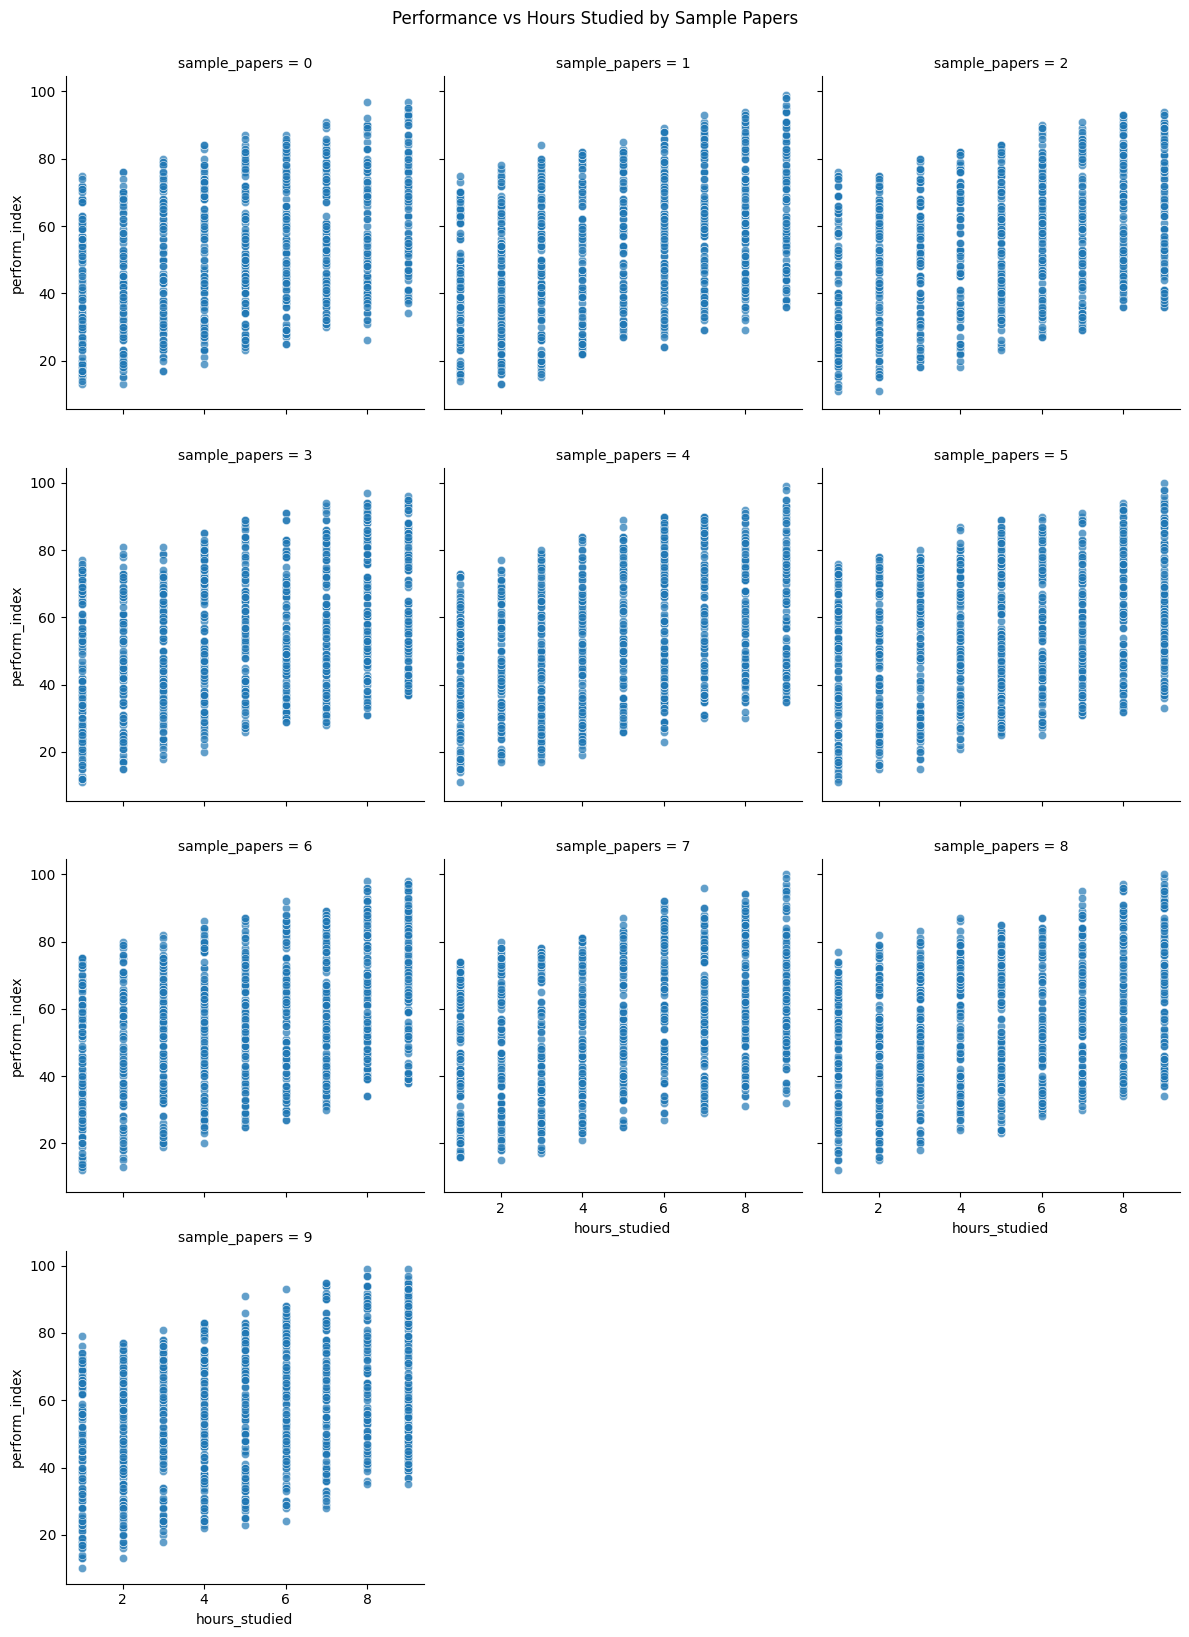

In [10]:
g = sns.FacetGrid(data, col="sample_papers", col_wrap=3, height=4)
g.map(sns.scatterplot, "hours_studied", "perform_index", alpha=0.7)
g.fig.suptitle("Performance vs Hours Studied by Sample Papers", y=1.02)
plt.show()



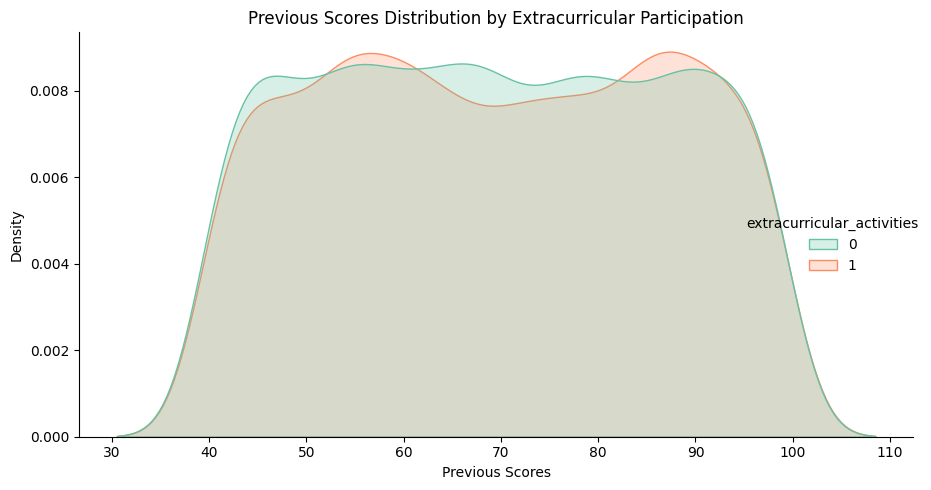

In [40]:
sns.displot(
    data=data,
    x="previous_scores",
    hue="extracurricular_activities",
    kind="kde",  
    fill=True,
    height=5,
    aspect=1.5,
    palette="Set2"
)
plt.title("Previous Scores Distribution by Extracurricular Participation")
plt.xlabel("Previous Scores")
plt.ylabel("Density")
plt.tight_layout()
plt.show()


- DIstribution suggest that there is no difference at all if student participated in extracurricular activities or not. 

In [ ]:
from scipy.stats import ks_2samp

group1 = data[data["extracurricular_activities"] == 1]["previous_scores"]
group0 = data[data["extracurricular_activities"] == 0]["previous_scores"]

statistic, p_value = ks_2samp(group1, group0)

print(f"KS statistic: {statistic:.4f}")
print(f"P-value: {p_value:.4f}")

if p_value < 0.05:
    print("Reject H_0: Distributions are significantly different (p < 0.05)")
else:
    print("Fail to reject h_0: No significant difference between distributions ")


KS statistic: 0.0170
P-value: 0.4587
Fail to reject h_0: No significant difference between distributions 


 There is no statistically significant difference in the distribution of previous scores between students who participate in extracurricular activities and those who do not.

In [ ]:
data["extracurricular_activities"].value_counts()

extracurricular_activities
0    5052
1    4948
Name: count, dtype: int64

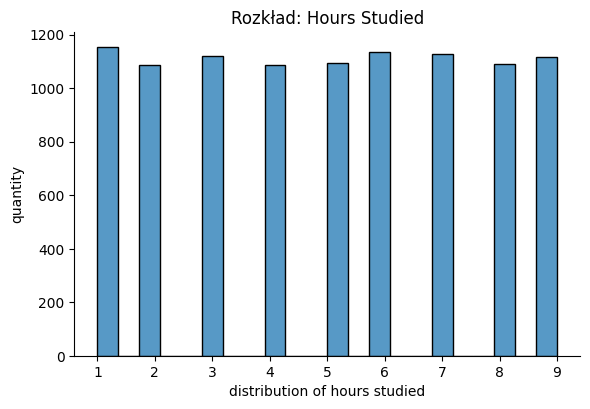

In [ ]:

score_bins = pd.cut(data["previous_scores"], bins=10)
data["score_interval"] = score_bins.astype(str)

sns.displot(data, x="hours_studied", height=4, aspect=1.5)
plt.title("Rozkład: Hours Studied")
plt.xlabel("distribution of hours studied")
plt.ylabel("quantity")
plt.show()

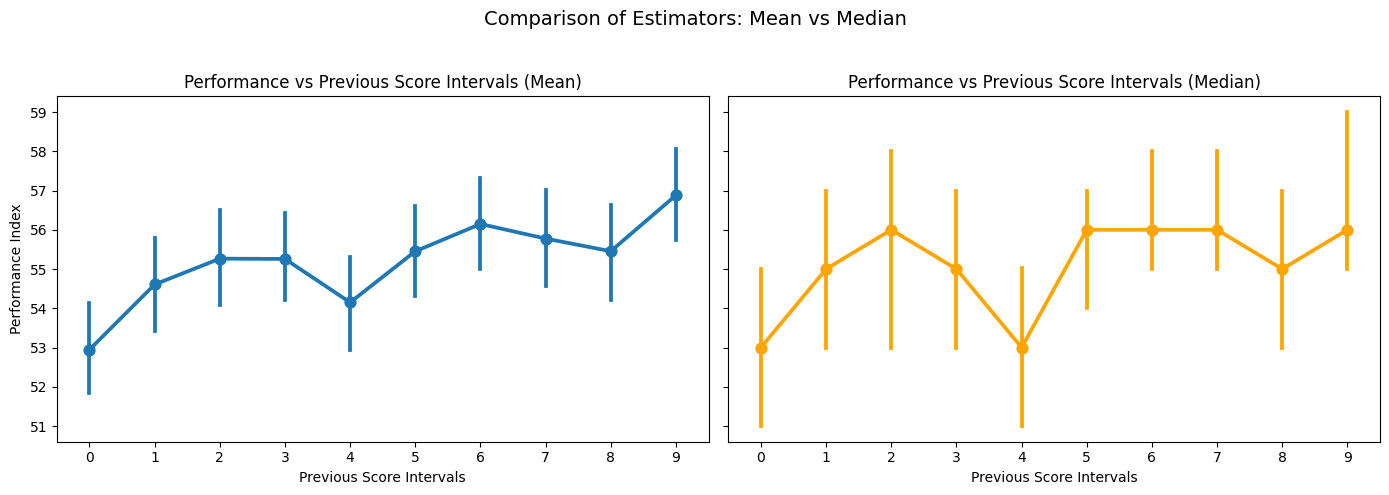

In [28]:
data["score_interval"] = pd.Categorical(data["score_interval"], ordered=True, categories=sorted(data["score_interval"].unique()))

fig, axes = plt.subplots(1, 2, figsize=(14, 5), sharey=True)

sns.pointplot(data=data, x="sample_papers", y="perform_index", estimator=np.mean, ax=axes[0])
axes[0].set_title("Performance vs Previous Score Intervals (Mean)")
axes[0].set_xlabel("Previous Score Intervals")
axes[0].set_ylabel("Performance Index")
axes[0].tick_params(axis='x')

sns.pointplot(data=data, x="sample_papers", y="perform_index", estimator=np.median, ax=axes[1], color='orange')
axes[1].set_title("Performance vs Previous Score Intervals (Median)")
axes[1].set_xlabel("Previous Score Intervals")
axes[1].set_ylabel("")

plt.suptitle("Comparison of Estimators: Mean vs Median", fontsize=14)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


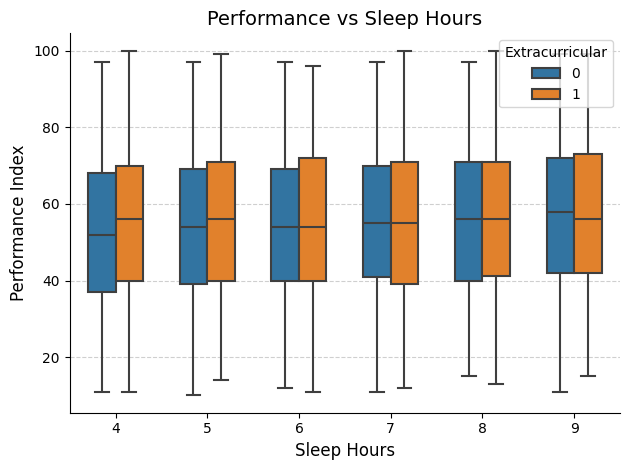

In [ ]:

sns.boxplot(
    data=data,
    x="sleep_hours",
    y="perform_index",
    width=0.6,
    linewidth=1.5,
    fliersize=5,
    hue="extracurricular_activities",
    showfliers=True
)
plt.title("Performance vs Sleep Hours", fontsize=14)
plt.xlabel("Sleep Hours", fontsize=12)
plt.ylabel("Performance Index", fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.6)
sns.despine()
plt.legend(title="Extracurricular", loc="upper right")  
plt.tight_layout()
plt.show()


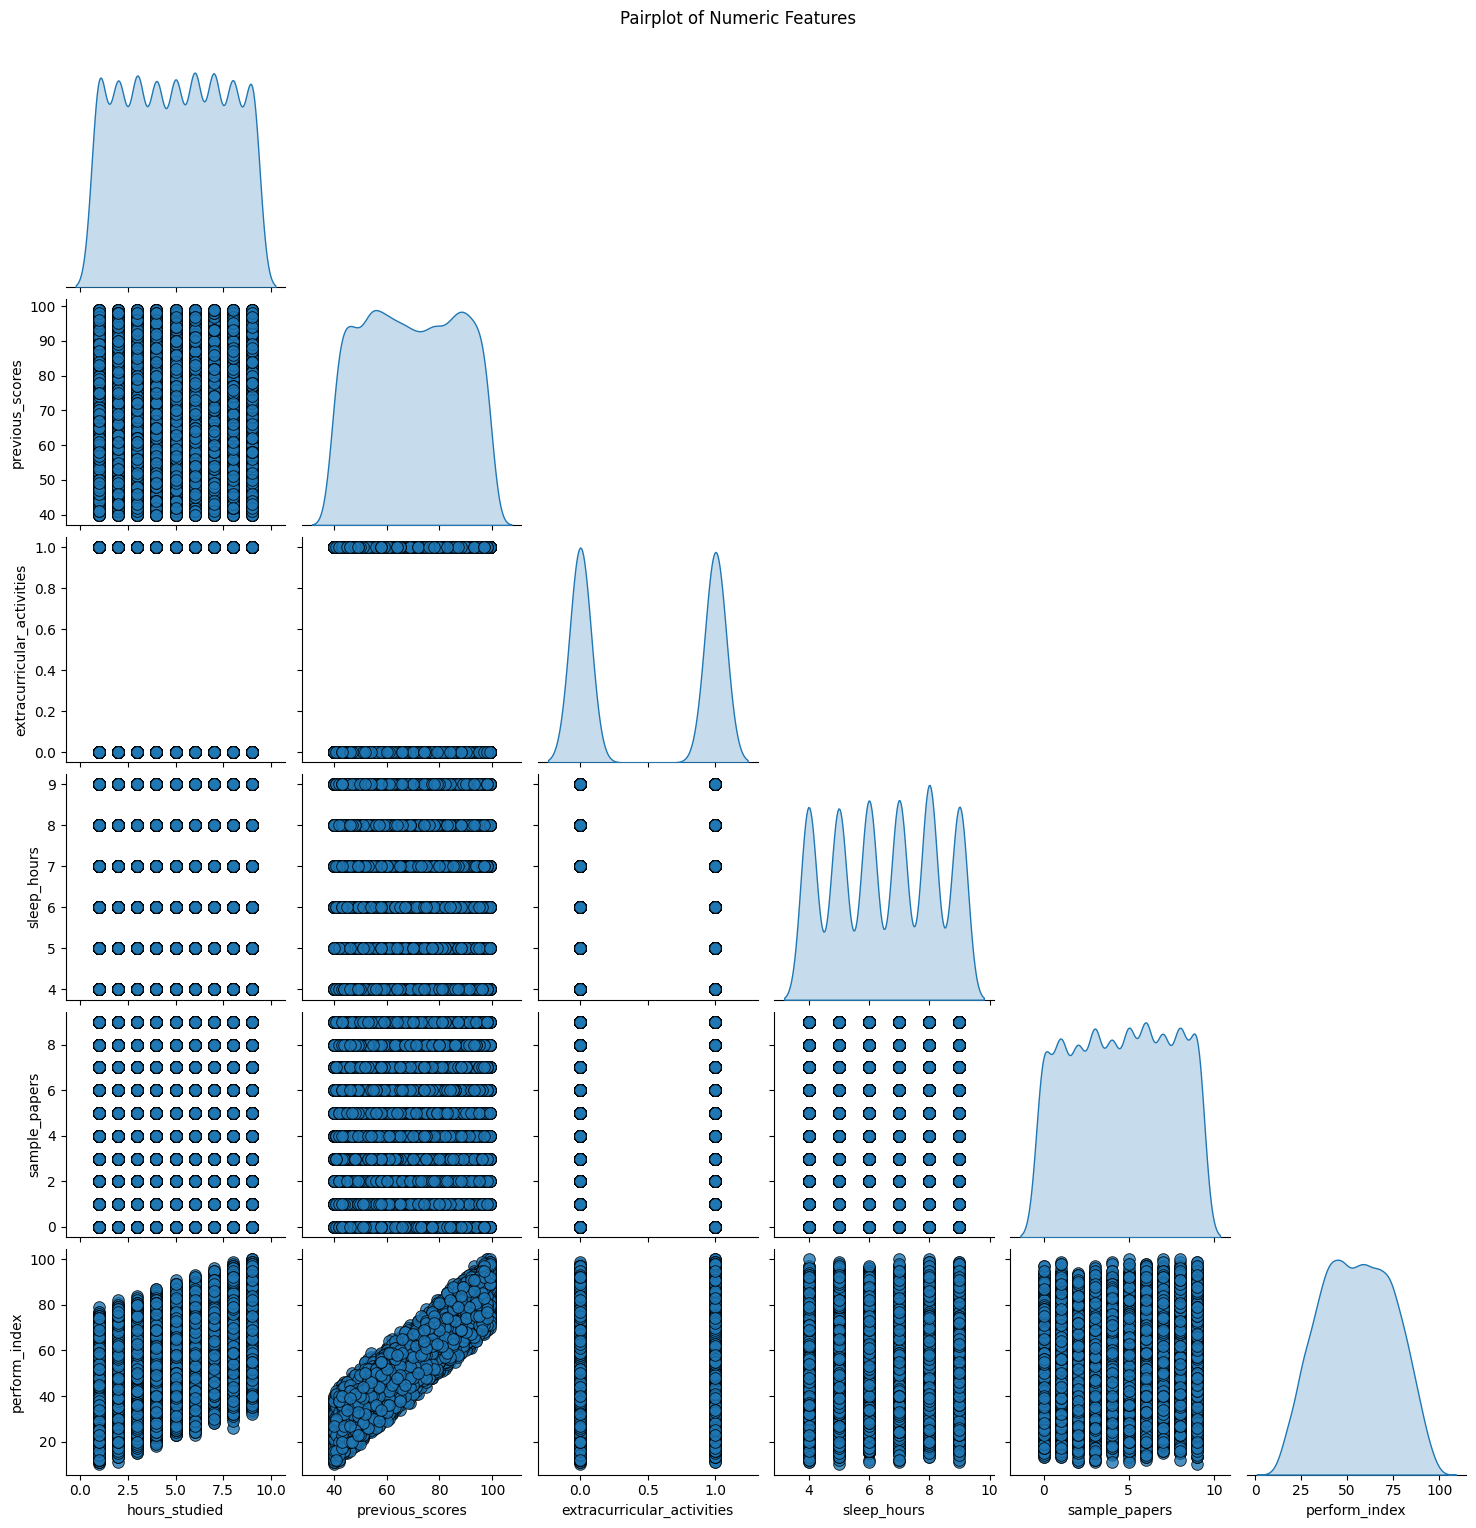

In [15]:
numeric_data = data.select_dtypes(include='number')


sns.pairplot(
    data=numeric_data,
    diag_kind="kde",
    corner=True,
    plot_kws={"alpha": 0.8, "s": 70, "edgecolor": "k"}
)
plt.suptitle("Pairplot of Numeric Features", y=1.02)
plt.show()

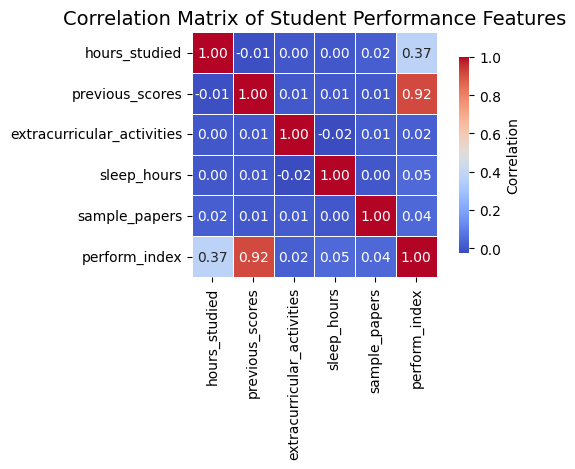

In [16]:
sns.heatmap(
    data.corr(numeric_only=True),
    annot=True,
    fmt=".2f",
    cmap="coolwarm",
    square=True,
    linewidths=0.5,
    cbar_kws={"shrink": 0.8, "label": "Correlation"},
    annot_kws={"fontsize": 10}
)
plt.title("Correlation Matrix of Student Performance Features", fontsize=14)
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()



- Given the heatmap there is no mulitcollinearity 

- but are goint to handle data in two ways

- 1: Using lasso regression in order to find the most important parameters to the model.
- 2: No changes at all. 



# CLRM




- Also we are treating performance index as the response variable, rest of them are explanatory variable.


In [ ]:

model = ols("perform_index~previous_scores+extracurricular_activities",data=data).fit()

print(model.summary())



                            OLS Regression Results                            
Dep. Variable:          perform_index   R-squared:                       0.838
Model:                            OLS   Adj. R-squared:                  0.838
Method:                 Least Squares   F-statistic:                 2.583e+04
Date:                Sun, 13 Apr 2025   Prob (F-statistic):               0.00
Time:                        20:35:22   Log-Likelihood:                -34648.
No. Observations:               10000   AIC:                         6.930e+04
Df Residuals:                    9997   BIC:                         6.932e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept           

**OLS Regression Results Summary:**

- **R-squared**: 0.838 ( explanatory variables explain approximately 83% of the variability in the response variable. )
- **Adjusted R-squared**: 0.838 (There are no redundant explanatory variables in the regression model)
- **p-value (F-statistic)**: 0.00 (At least one explanatory variable contributes to explaining the variability in the response variable. )
- **AIC**: 6.93 × 10^4 (Lower AIC indicates better fit)
- **BIC**: 6.93 × 10^4 (Lower BIC indicates better fit)

**Coefficients:**
- **Intercept**: -15.4916 (Statistically significant, p < 0.000)
- **previous_scores**: 1.0137 (Significant, p < 0.000, 1 unit increase in previous scores increases the perform index by 1.0137)
- **extracurricular_activities**: 0.6481 (Significant, p < 0.000, 1 unit increase in extracurricular activities increases the perform index by 0.6481)

**Diagnostics:**
- **Omnibus test**: 2584.000 (p < 0.05 suggests non-normality of residuals)
- **Durbin-Watson**: 2.027 (No first order autocorrelation)
- **Condition Number**: 305 (No significant multicollinearity)

**Conclusion**: The model is statistically significant, and both *previous_scores* and *extracurricular_activities* are important predictors of *perform_index*, with *previous_scores* having a stronger impact.


Checking assumptions of CLRM 

- Homoscedasticity 

- Autocorrelation

- Normality of residual

- Endogenity 

- Multicollinearity (was tested before by using corr_matrix but we will add up VIF). Also there is no perfect multicollinearity thus the critical assumption is met.

- The OLS model runs successfully, it means the explanatory variable matrix (X) is not singular.



## 1 Homscedasticity 

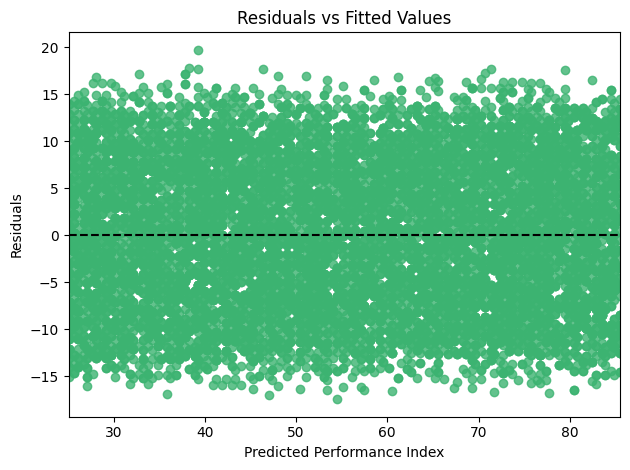

In [19]:
fitted_vals = model.fittedvalues
residuals = model.resid

sns.residplot(x=fitted_vals, y=residuals, lowess=True, color="mediumseagreen")
plt.axhline(0, color="black", linestyle="--")
plt.xlabel("Predicted Performance Index")
plt.ylabel("Residuals")
plt.title("Residuals vs Fitted Values")
plt.tight_layout()
plt.show()

- No patterns suggests that there is no autocorrelation.
- And similar structure of residuals tells use that there is also no homscedasticity.
- Let's test this.   

### Goldfelf-Quant test 

- Hypothesis :

In [49]:
gq_test = het_goldfeldquandt(model.resid, model.model.exog)

print(f"F-statistic: {gq_test[0]:.4f} p-value:{gq_test[1]:.4f}")

if gq_test[1] < 0.05:
    print("Likely heteroskedasticity -> (reject H0)")
else:
    print("No evidence of heteroskedasticity -> fail to reject H0")

F-statistic: 1.0138 p-value:0.3138
No evidence of heteroskedasticity -> fail to reject H0


### White-Test 

- based on auxillary regression

- Hypothesis :

In [50]:
white_test = het_white(model.resid, model.model.exog)


labels = ["LM Statistic", "LM p-value", "F Statistic", "F p-value"]
for label, stat in zip(labels, white_test):
    print(f"{label}: {stat:.4f}")

if white_test[1] < 0.05:
    print(" Likely heteroskedasticity -> (reject H0)")
else:
    print(" No evidence of heteroskedasticity -> (fail to reject H0)")


LM Statistic: 8.4045
LM p-value: 0.0778
F Statistic: 2.1018
F p-value: 0.0778
 No evidence of heteroskedasticity -> (fail to reject H0)


### **Conclusion:**  

- Both tests suggest that there is no heteroscedasticity

## 2 Normality of residual 

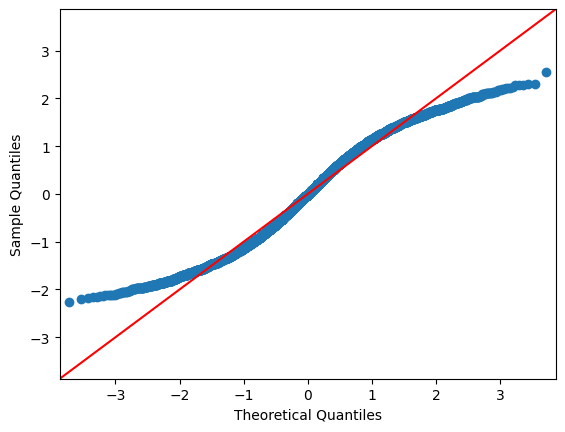

In [22]:
qqplot(model.resid,fit=True,line="45")

plt.show()

- QQ-Plot suggests that our residuals are not normally distributed, lets test it then.

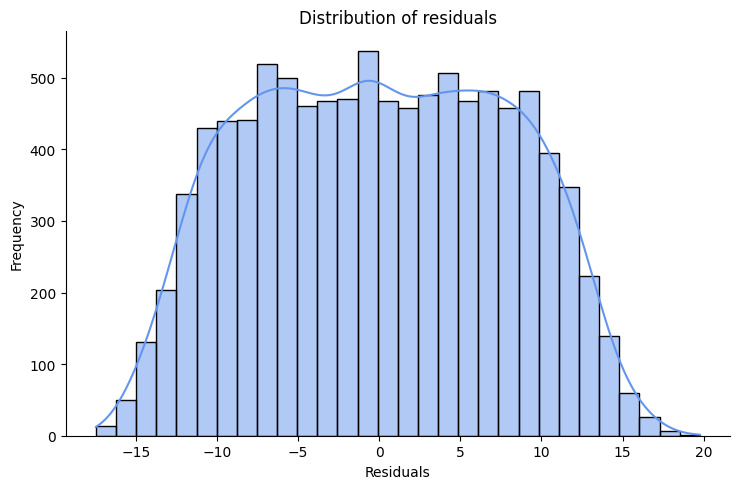

In [23]:

sns.displot(
    residuals,
    kde=True,
    bins=30,
    height=5,
    aspect=1.5,
    color="cornflowerblue"
)

plt.title("Distribution of residuals")
plt.xlabel("Residuals")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()


There are numerous statistical tests to assess normality, including Shapiro–Wilk, Anderson–Darling, Jarque–Bera, D’Agostino’s K², and others.

In my analysis, i have selected two of them. 

- Cramer-von Mises

- Jarque–Bera

- I did not use Shapiro-wilk test, since it's not working for samples above 5 thousands. 

### Jarque bera

In [51]:
jb_stat, jb_pval, skew, kurt = jarque_bera(residuals)

print(f"JB statistic: {jb_stat:.4f} p-val: {jb_pval:.4f}")

if jb_pval < 0.05:
    print("→ Residuals are likely NOT normally distributed (reject H0)")
else:
    print("→ Residuals appear to be normally distributed (fail to reject H0)")

JB statistic: 436.0549 p-val: 0.0000
→ Residuals are likely NOT normally distributed (reject H0)


### Cramer-Von Mises

In [52]:

result = cramervonmises(residuals, 'norm')

print(f"Statistic: {result.statistic:.4f} {result.pvalue:.4f}")

if result.pvalue < 0.05:
    print("Residuals are likely NOT normally distributed ->  (reject H0)")
else:
    print("Residuals appear to be normally distributed -> (fail to reject H0)")

Statistic: 623.0807 0.0000
Residuals are likely NOT normally distributed ->  (reject H0)


### **Conclusion** 

- Since the normality is not met, we will weaken the assumption to the white noise. 

- Thus our residuals have to meet those 3 criteries in order to be a white noise

- expected Value from residuals is equals 0

- Constant variance (Homscedasticity)

- No autocorrelation 

#### **Residauls mean** 

In [48]:
np.mean(model.resid)

1.1283418643870392e-14

- This assumption is satisfied — which is not surprising at all, since every linear model exhibits this property as long as it is linear with respect to its parameters

- Homoscedascity is met which was tested previously

## 3 **Autocorrelation**

- In the model summary, we see the Durbin-Watson statistic, which tests for first-order autocorrelation. The value is approximately 2, indicating that there is no first-order autocorrelation

- Our data is not time series data, so it is not strictly necessary to test for autocorrelation further — but we will do it anyway for completeness


### Breusch-Godfrey 

- Based on the auxillary regression

In [56]:
bg_test = acorr_breusch_godfrey(model, nlags=4)

bg_labels = ['LM Statistic', 'LM-Test p-value', 'F-Statistic', 'F-Test p-value']
bg_results = dict(zip(bg_labels, bg_test))

bg_p_value = bg_results['LM-Test p-value']

if bg_p_value < 0.05:
    print(f" p-value = {bg_p_value:.4f} Reject H0 → Autocorrelation detected.")
else:
    print(f"p-value = {bg_p_value:.4f} → Fail to reject H0 → No evidence of autocorrelation.")


p-value = 0.5452 → Fail to reject H0 → No evidence of autocorrelation.


- There is no autocorrelation up to fourth order, thus our white noise assumption is met and CLRM assumption.   

## 4 Imperfect Multicollinearity 


### Variance Inflation Factor

In [ ]:

X = data[['previous_scores', 'extracurricular_activities']]  
X = add_constant(X)  

vif_data = pd.DataFrame()
vif_data['Variable'] = X.columns
vif_data['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

print(vif_data)

                     Variable        VIF
0                       const  17.949603
1             previous_scores   1.000070
2  extracurricular_activities   1.000070


- Given the VIF values, there is no multicollinearity in the model. The VIFs for the independent variables in the model.

## 5 Endogenity

In [ ]:
correlation_previous_scores = data['previous_scores'].corr(residuals)
correlation_extracurricular_activities = data['extracurricular_activities'].corr(residuals)

print(f" corr previous_scores and residuals: {correlation_previous_scores}")
print(f"corr extracurricular_activities and resid: {correlation_extracurricular_activities}")

 cor previous_scores and residuals: -5.238426939126021e-16
corr extracurricular_activities and resid: -5.47635069133399e-16


- We have simplified the assessment of endogeneity by checking the correlation between the explanatory variables and the residuals.



### RESET Ramsay test

In [ ]:
reset_test = reset_ramsey(model)

f_statistic = reset_test.fvalue  
p_value = reset_test.pvalue  

if p_value > 0.05:
    print("The model is well-specified, no changes needed.")
else:
    print("The model is mis-specified and may require adjustments.")


The model is well-specified, no changes needed.



#### What does it mean for a model to be "mis-specified"?

A model is considered "mis-specified" when it is incorrectly formulated, which can happen if:
- Important variables are left out of the model.
- The functional form of the model (e.g., linear vs. non-linear) is incorrect.
- There are issues such as endogeneity or measurement errors that lead to inaccurate estimates.

# Conclusion

This version clearly states that the model is valid because all the necessary assumptions for regression have been satisfied, ensuring that the results can be trusted.